In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def one_hot_encode(y, num_classes):
    return np.eye(num_classes)[y]

In [3]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = np.frombuffer(data, dtype=np.uint8, offset=16).reshape(n_images, n_rows, n_cols)
        return images, n_images


def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = np.frombuffer(data, dtype=np.uint8, offset=8)
        return labels


x, num_inputs = read_mnist_images('mnist/train-images.idx3-ubyte')
x = x.reshape((-1, 1, 28, 28))
x = x / 255.
y = one_hot_encode(read_mnist_labels('mnist/train-labels.idx1-ubyte'), 10)

In [188]:
class LayerDense:
    def __init__(self, n_inputs, n_neurons):
        rng = np.random.default_rng()
        variance = np.sqrt(6/(n_inputs + n_neurons))
        self.weights = (rng.standard_normal(size=(n_inputs, n_neurons))) * variance # xavier initialization from tensorflow
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs


    def backward(self, d_values):
        self.dweights = np.dot(self.inputs.T, d_values) / len(self.inputs)
        self.dbiases = np.sum(d_values, axis=0, keepdims=True) / len(self.inputs)
        self.dinputs = np.dot(d_values, self.weights.T) / len(self.inputs)

In [149]:
class LayerConvolutional:
    def __init__(self, num_kernels, num_channels, kernel_size):
        rng = np.random.default_rng()
        variance = 1/10
        #self.weights =  0.1 * rng.standard_normal(size=(num_kernels, num_channels, kernel_size, kernel_size))
        self.weights = (2*rng.standard_normal(size=(num_kernels, num_channels, kernel_size, kernel_size))) * variance
        self.biases = np.zeros(num_kernels)
        self.kernel_size = kernel_size
        self.num_kernels = num_kernels
        self.num_channels = num_channels
    
    def forward(self, inputs):
        if hasattr(self, 'output'):
            delattr(self, 'output')
        self.pad_size_rows = inputs.shape[-2] - (inputs.shape[-2] - self.kernel_size + 1)
        self.pad_size_cols = inputs.shape[-1] - (inputs.shape[-1] - self.kernel_size + 1)
        self.inputs = inputs
        self.padded_inputs = np.pad(inputs, ((0, 0), (0, 0), (0, self.pad_size_rows), (0, self.pad_size_cols)))
        if self.num_channels != self.inputs.shape[1]:
            raise Exception('Error: number of filter and image channels does not match.')
        for kernel, bias in zip(self.weights, self.biases):
            if not hasattr(self, 'output'):
                self.output = sp.signal.convolve(self.padded_inputs, [kernel], mode='valid') + bias
            else:
                self.output = np.append(self.output, sp.signal.convolve(self.padded_inputs, [kernel], mode='valid') + bias, axis=1)
    
    def backward(self, d_values):
        self.dbiases = np.zeros_like(self.biases)
        self.dinputs = np.zeros_like(self.inputs)
        if hasattr(self, 'dweights'):
            delattr(self, 'dweights')
        for kernel_id in range(self.num_kernels):
            kernel = self.weights[kernel_id]
            rotated_kernel = np.rot90(kernel, k=2, axes=(1, 2))
            per_kernel_dvalues = d_values[:, kernel_id:(kernel_id+1), :, :]
            for channel_id in range(self.num_channels):
                channel_rot_kernel = rotated_kernel[channel_id]
                channel_inputs = self.padded_inputs[:, channel_id:channel_id+1, :, :]
                if channel_id == 0:
                    cur_dfilter = sp.signal.convolve(channel_inputs, per_kernel_dvalues, mode='valid').reshape((-1, 1, self.kernel_size, self.kernel_size))
                else:
                    cur_dfilter = np.append(cur_dfilter, sp.signal.convolve(channel_inputs, per_kernel_dvalues, mode='valid').reshape((-1, 1, self.kernel_size, self.kernel_size)), axis=1)
                self.dinputs[:, channel_id:channel_id+1, :, :] += sp.signal.convolve(per_kernel_dvalues, [[channel_rot_kernel]], mode='full')[:, :, (self.pad_size_rows//2):-(self.pad_size_rows//2), (self.pad_size_cols//2):-(self.pad_size_cols//2)]
            if not hasattr(self, 'dweights'):
                self.dweights = cur_dfilter
            else:
                self.dweights = np.append(self.dweights, cur_dfilter, axis=0)
            self.dbiases[kernel_id] += np.sum(per_kernel_dvalues)
            
            self.dbiases /= len(self.inputs)
            self.dinputs /= len(self.inputs)
            self.dweights /= len(self.inputs)

In [59]:
class LayerMaxPooling:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride
    
    def forward(self, inputs):
        self.inputs = inputs
        pad_cols = self.inputs.shape[-1] % self.stride if self.inputs.shape[-1] % self.stride != 0 else 0
        pad_rows = self.inputs.shape[-2] % self.stride if self.inputs.shape[-2] % self.stride != 0 else 0
        self.padded_inputs = np.pad(inputs, ((0, 0), (0, 0), (0, pad_rows), (0, pad_cols))) if pad_cols or pad_rows else inputs
        self.windowed_padded_inputs = np.lib.stride_tricks.sliding_window_view(self.padded_inputs, (self.kernel_size, self.kernel_size), axis=(2, 3))[:, :, ::self.stride, ::self.stride]
        self.output = self.windowed_padded_inputs.max(axis=(4, 5))
        
    def backward(self, d_values):
        self.dinputs = np.zeros_like(self.inputs)
        samples, channels, rows, cols, window_rows, window_cols = self.windowed_padded_inputs.shape
        for sample in range(samples):
            for channel_id in range(channels):
                for row in range(rows):
                    for col in range(cols):
                        window = self.windowed_padded_inputs[sample, channel_id, row, col]
                        max_id = np.argmax(window)
                        row_placement_in_block = max_id // window_cols
                        col_placement_in_block = max_id % window_cols
                        self.dinputs[sample, channel_id, window_rows*row + row_placement_in_block, window_cols*col + col_placement_in_block] = d_values[sample, channel_id, row, col]

In [7]:
class LayerFlatten:
    def forward(self, inputs):
        self.num_samples, self.num_channels, self.num_rows, self.num_cols = inputs.shape
        self.output = inputs.reshape((self.num_samples, self.num_channels * self.num_rows * self.num_cols))
    
    def backward(self, d_values):
        self.dinputs = d_values.reshape((self.num_samples, self.num_channels, self.num_rows, self.num_cols))

In [8]:
class ActivationReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        self.inputs = inputs

    def backward(self, d_values):
        self.dinputs = d_values.copy()
        self.dinputs[self.inputs <= 0] = 0

In [9]:
class ActivationSoftmaxLossCategoricalCrossentropy:
    def forward(self, inputs, correct_labels):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) # -np.max(...) for numerical stability with big number
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        predictions = np.clip(self.output, 1e-7, 1 - 1e-7)
        loss = np.sum(-np.log(predictions) * correct_labels)
        return loss

    def backward(self, dvalues, correct_labels):
        self.dinputs = dvalues - correct_labels

In [39]:
class OptimizerSGD:
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate 
        self.decay = decay 
        self.iterations = 0 
        self.momentum = momentum

    def pre_update_params(self): 
        if self.decay: 
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum: 
            if not hasattr(layer, 'weight_momentums'): 
                layer.weight_momentums = np.zeros_like(layer.weights) 
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights 
            layer.weight_momentums = weight_updates 
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases 
            layer.bias_momentums = bias_updates
        else:
            weight_updates = -self.learning_rate * layer.dweights
            bias_updates = -self.learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

In [40]:
class Network:
    def __init__(self, layers=[], optimizer=None):
        self.layers = layers
        self.optimizer = optimizer
    
    def add(self, layer):
        self.layers.append(layer)
    
    def forward_propagation(self, x_batch, y_batch):
        prev_layer = None
        for layer in self.layers:
            layer_input = x_batch if prev_layer is None else prev_layer.output
            if isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                loss = layer.forward(layer_input, y_batch)
            else:
                layer.forward(layer_input)
            prev_layer = layer
        return loss
    
    def back_propagation(self, y_batch):
        layers_reversed = self.layers[::-1]
        prev_layer = None
        adjustable_layers = (LayerDense, LayerConvolutional)
        for layer in layers_reversed:
            if isinstance(layer, ActivationSoftmaxLossCategoricalCrossentropy):
                layer.backward(layer.output, y_batch)
            else:
                layer.backward(prev_layer.dinputs)
            prev_layer = layer
        self.optimizer.pre_update_params()
        for layer in self.layers:
            if isinstance(layer, adjustable_layers):
                self.optimizer.update_params(layer)
        self.optimizer.post_update_params()
    
    def train(self, x, y, epochs, batch_size):
        for i in range(epochs):
            for j in range(0, len(x), batch_size):
                x_batch = x[j:j+batch_size]
                y_batch = y[j:j+batch_size]
                loss = self.forward_propagation(x_batch, y_batch)
                self.back_propagation(y_batch)
                predictions = np.argmax(self.layers[-1].output, axis=1)
                accuracy = np.mean(predictions == np.argmax(y_batch, axis=1))
            print(f'epoch: {i}, ' + f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')

In [203]:
x, num_inputs = read_mnist_images('mnist/train-images.idx3-ubyte')
x = x.reshape((-1, 1, 28, 28))
x = x.reshape(-1, 784) / 255.
y = one_hot_encode(read_mnist_labels('mnist/train-labels.idx1-ubyte'), 10)

In [204]:
network1 = Network([
    LayerDense(784, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD())
epochs = 100
batch_size = 60
x = x.reshape(-1, 784)
network1.train(x, y, epochs, batch_size)

epoch: 0, acc: 0.950, loss: 11.423
epoch: 1, acc: 0.950, loss: 9.307
epoch: 2, acc: 0.950, loss: 8.167
epoch: 3, acc: 0.967, loss: 7.712
epoch: 4, acc: 0.967, loss: 7.238
epoch: 5, acc: 0.950, loss: 7.094
epoch: 6, acc: 0.950, loss: 6.799
epoch: 7, acc: 0.967, loss: 6.472
epoch: 8, acc: 0.967, loss: 6.253
epoch: 9, acc: 0.967, loss: 6.045
epoch: 10, acc: 0.967, loss: 5.876
epoch: 11, acc: 0.967, loss: 5.687
epoch: 12, acc: 0.967, loss: 5.465
epoch: 13, acc: 0.967, loss: 5.365
epoch: 14, acc: 0.967, loss: 5.294
epoch: 15, acc: 0.967, loss: 5.250


KeyboardInterrupt: 

In [119]:
count = 0
for test_sample_num in range(10000):
    x_test, num_inputs = read_mnist_images('mnist/t10k-images.idx3-ubyte')
    x_test_flat = x_test.reshape(-1, 784) / 255.
    y_test = one_hot_encode(read_mnist_labels('mnist/t10k-labels.idx1-ubyte'), 10)
    network1.forward_propagation(x_test_flat[test_sample_num:test_sample_num+1, :], y_test)
    pred = np.argmax(network1.layers[-1].output)
    correct = np.argmax(y_test[test_sample_num])
    if pred != correct:
        count += 1
print(count)
print(f'Network Prediction: {pred}')
print(f'Correct Prediction: {correct}')
#plt.imshow(x_test[test_sample_num], cmap='gray')


612
Network Prediction: 6
Correct Prediction: 6


In [120]:
count/10000

0.0612

In [170]:
x_fashion, num_inputs_fashion = read_mnist_images('fashion_mnist/train-images-idx3-ubyte')
x_fashion = x.reshape((-1, 1, 28, 28))
x_fashion = x_fashion.reshape(-1, 784) / 255.
y_fashion = one_hot_encode(read_mnist_labels('fashion_mnist/train-labels-idx1-ubyte'), 10)

In [151]:
network = Network([
    LayerConvolutional(3, 1, 3),
    ActivationReLU(),
    LayerMaxPooling(),
    LayerConvolutional(2, 3, 3),
    ActivationReLU(),
    LayerMaxPooling(),
    LayerFlatten(),
    LayerDense(98, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD())

epochs = 100
batch_size = 10

network.train(x_fashion, y_fashion, epochs, batch_size)

epoch: 0, acc: 0.100, loss: 23.029
epoch: 1, acc: 0.100, loss: 23.029


KeyboardInterrupt: 

In [198]:
network = Network([
    LayerDense(784, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationReLU(),
    LayerDense(10, 10),
    ActivationSoftmaxLossCategoricalCrossentropy()
], OptimizerSGD(learning_rate=0.01))

epochs = 100
batch_size = 10

network.train(x_fashion, y_fashion, epochs, batch_size)

epoch: 0, acc: 0.900, loss: 6.310
epoch: 1, acc: 0.800, loss: 4.336
epoch: 2, acc: 0.900, loss: 3.745
epoch: 3, acc: 0.900, loss: 3.512
epoch: 4, acc: 0.900, loss: 3.354
epoch: 5, acc: 0.900, loss: 3.257
epoch: 6, acc: 0.800, loss: 3.185
epoch: 7, acc: 0.800, loss: 3.100
epoch: 8, acc: 0.800, loss: 3.031
epoch: 9, acc: 0.800, loss: 2.970
epoch: 10, acc: 0.800, loss: 2.915
epoch: 11, acc: 0.800, loss: 2.857
epoch: 12, acc: 0.800, loss: 2.809
epoch: 13, acc: 0.800, loss: 2.784
epoch: 14, acc: 0.800, loss: 2.734
epoch: 15, acc: 0.800, loss: 2.708
epoch: 16, acc: 0.800, loss: 2.677
epoch: 17, acc: 0.800, loss: 2.651
epoch: 18, acc: 0.800, loss: 2.623
epoch: 19, acc: 0.800, loss: 2.597
epoch: 20, acc: 0.800, loss: 2.567
epoch: 21, acc: 0.800, loss: 2.539
epoch: 22, acc: 0.800, loss: 2.512
epoch: 23, acc: 0.800, loss: 2.481
epoch: 24, acc: 0.800, loss: 2.453
epoch: 25, acc: 0.800, loss: 2.426
epoch: 26, acc: 0.800, loss: 2.404
epoch: 27, acc: 0.800, loss: 2.385
epoch: 28, acc: 0.800, loss: 2

Network Prediction: 3
Correct Prediction: 3


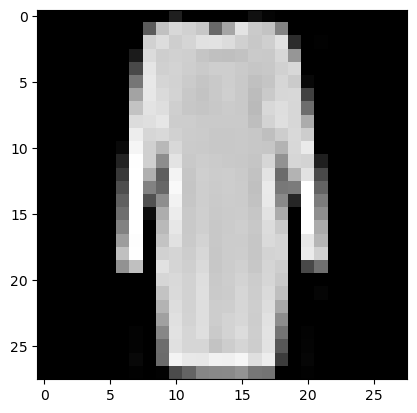

In [202]:
test_sample_num = 301
x_test, num_inputs = read_mnist_images('fashion_mnist/t10k-images-idx3-ubyte')
x_test_flat = x_test.reshape(-1, 784) / 255.
y_test = one_hot_encode(read_mnist_labels('fashion_mnist/t10k-labels-idx1-ubyte'), 10)
network.forward_propagation(x_test_flat[test_sample_num:test_sample_num+1, :], y_test)
print(f'Network Prediction: {np.argmax(network.layers[-1].output)}')
print(f'Correct Prediction: {np.argmax(y_test[test_sample_num])}')
plt.imshow(x_test[test_sample_num], cmap='gray')


In [199]:
count = 0
for test_sample_num in range(10000):
    x_test, num_inputs = read_mnist_images('fashion_mnist/t10k-images-idx3-ubyte')
    x_test_flat = x_test.reshape(-1, 784) / 255.
    y_test = one_hot_encode(read_mnist_labels('fashion_mnist/t10k-labels-idx1-ubyte'), 10)
    network.forward_propagation(x_test_flat[test_sample_num:test_sample_num+1, :], y_test)
    pred = np.argmax(network.layers[-1].output)
    correct = np.argmax(y_test[test_sample_num])
    if pred != correct:
        count += 1
print(count)
print(f'Network Prediction: {pred}')
print(f'Correct Prediction: {correct}')
#plt.imshow(x_test[test_sample_num], cmap='gray')


1602
Network Prediction: 5
Correct Prediction: 5


In [179]:
model  = tf.keras.models.Sequential([
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [197]:
print(model.optimizer.learning_rate.value)

<tf.Variable 'SGD/learning_rate:0' shape=() dtype=float32, numpy=0.01>


In [181]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [182]:
x_fashion, num_inputs_fashion = read_mnist_images('fashion_mnist/train-images-idx3-ubyte')
x_fashion = x_fashion.reshape(-1, 784) / 255.
y_fashion = one_hot_encode(read_mnist_labels('fashion_mnist/train-labels-idx1-ubyte'), 10)

In [183]:
history = model.fit(x_fashion, y_fashion, epochs=20, batch_size=20)

Epoch 1/20


/opt/homebrew/anaconda3/envs/NNFS/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:559: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.6597 - loss: 1.0089
Epoch 2/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8315 - loss: 0.4829
Epoch 3/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8521 - loss: 0.4228
Epoch 4/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8597 - loss: 0.3957
Epoch 5/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8698 - loss: 0.3707
Epoch 6/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step - accuracy: 0.8768 - loss: 0.3484
Epoch 7/20
1704/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8796 - loss: 0.3340

KeyboardInterrupt: 

In [172]:
x_test, num_inputs = read_mnist_images('fashion_mnist/t10k-images-idx3-ubyte')
x_test_flat = x_test.reshape(-1, 784) / 255.
y_test = one_hot_encode(read_mnist_labels('fashion_mnist/t10k-labels-idx1-ubyte'), 10)